In [1]:
%matplotlib inline

In [2]:
import re
import time
import json
from os import path
from collections import Counter
import copy

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import division, unicode_literals
from __future__ import print_function
from nltk.stem import *
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

import sys
reload(sys)
sys.setdefaultencoding('utf-8')

Using http://peekaboo-vision.blogspot.com/2012/11/a-wordcloud-in-python.html

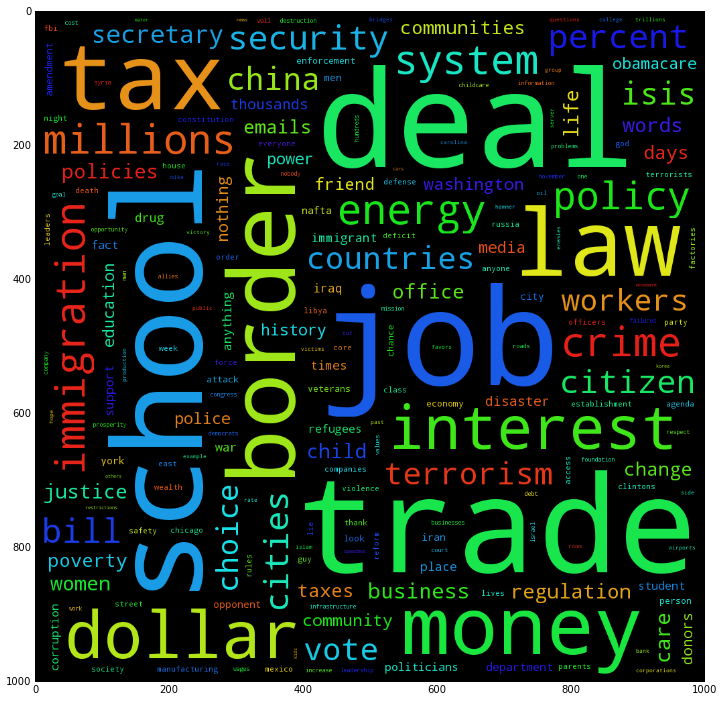

In [8]:
ignore_words = ['i','years',']','laughter','plan','way','lot','thing','things','matter',
                'reason',' ','[','%','day','year','today',
                'trump','donald','hillary','clinton','romney','obama','mccain','barack',
               'mitt','romney','kerry','george','bush;'
               'today','families','country','time','state','states','something','right',
               'kind',
               'people','children','president','home','part',
               'senator','everything','problem','future','issue','question','hampshire',
               'election','bush','member','audience','everybody','folks','applause',
               'cheers','thank','thanks',
               'america', 'americans', 'family', 'campaign', 'administration',
               'members', 'government', 'world', 'number','nation']

all_campaigns = ["Kerry_2004","Obama_2008","McCain_2008","Obama_2012",
                 "Romney_2012","Hillary_2016","Trump_2016"]

for campaign_str in all_campaigns:
    campaign_file = "../out/" + campaign_str + ".json"

    with open(campaign_file, "r") as infile:
        campaign_data = json.load(infile)

    ### Aggregated speeches
    stemmer = SnowballStemmer("english")
    all_speeches = ""

    for title in campaign_data:
        #all_speeches += campaign_data[title]['speech']
        all_speeches += stemmer.stem(campaign_data[title]['speech'])
    
    ### Using NLTK
    
    nltk_tokens = word_tokenize(all_speeches)
    nouns = [token for token, pos in pos_tag(nltk_tokens) if pos.startswith('N')]
    df_noun_count = pd.DataFrame(pd.Series(dict(Counter(nouns))), columns=["count"])
    df_noun_count['word'] = df_noun_count.index
    df_noun_count = df_noun_count.reset_index(drop=True)
    df_noun_count['word'].map(lambda x: (re.sub('[^A-Za-z]+', ' ',x)))
    df_noun_count = df_noun_count[df_noun_count['word'].map(
            lambda x: (x not in ignore_words) and len(x) > 1)]
    
    df_noun_count_small = df_noun_count.sort("count", ascending=False).head(1000)
    df_noun_count_small.head(50)
    df_noun_count_small.to_csv('../out/' + campaign_str + '_top_words.csv')

    ### Paste back into wordcloud with reduced file
    df_compressed_count = copy.deepcopy(df_noun_count)
    df_compressed_count['count'] = df_compressed_count['count'] / 10
    df_compressed_count['count'] = df_compressed_count['count'].astype(int)
    df_compressed_count = df_compressed_count[df_compressed_count['count'] > 1]

    #df_compressed_count.sort("count", ascending=False)
    new_string = ""
    for idx, row in df_compressed_count.iterrows():
        new_string += (row["word"] + " ") * row["count"] + " "
    cv = CountVectorizer(min_df=0, stop_words="english", max_features=200)
    counts = cv.fit_transform([new_string]).toarray().ravel()
    scaled_counts = counts / float(counts.max())
    words = np.array(cv.get_feature_names())
    
    #generate word cloud
    mask1 = np.empty([1000,1000])
    wordcloud = WordCloud(mask = mask1, margin=20).generate(new_string)
    plt.figure(1, figsize=(12,12))
    plt.imshow(wordcloud)
    plt.savefig('../img/' + campaign_str + '_word_cloud.png')
